# Left Side

x values where y=0.5: [2.77585291 4.74427283 5.0637973 ]


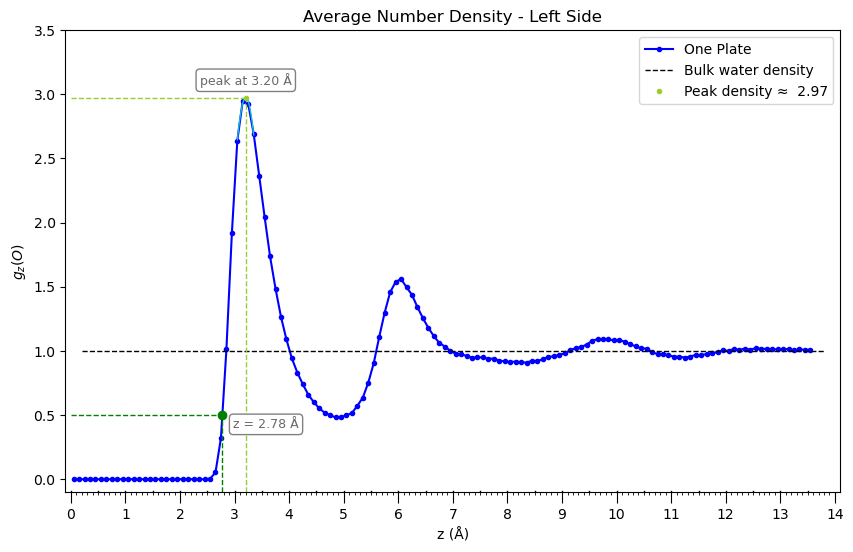

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
import numpy as np
import os

input_file = '/gibbs/joecruz/wu_hydroplates/one_plate/gzInterference/leftSide.dat'
output_path = '/gibbs/arghavan/hp-results-pc/'

data = np.loadtxt(input_file)

number_of_voxels = 170*170

x = data[:, 0]
number_density = data[:, 1]/number_of_voxels

# np.savetxt(f'{output_path}gZ-one-plate-300K-leftSide.dat', 
#         np.column_stack((x, number_density)), 
#         header='x (Angstrom)    g_z(O)', 
#         comments='')

half_density = 0.5
idx = np.where(np.diff(np.sign(number_density - half_density)))[0]
x_for_half = x[idx] + (half_density - number_density[idx]) * (x[idx+1] - x[idx]) / (number_density[idx+1] - number_density[idx])

print("x values where y=0.5:", x_for_half)


plt.figure(figsize=(10, 6))
plt.plot(x, number_density, 'bo-', markersize=3, label='One Plate', zorder=2)

plt.hlines(y=1.00, xmin=0.2, xmax=13.8, color='black', linestyle='--', linewidth=1, label='Bulk water density')
plt.hlines(y=0.5, xmin=0, xmax=x_for_half[0], color='green', linestyle='--', linewidth=1)

plt.vlines(x=x_for_half[0], ymin=-0.1, ymax=0.5, color='green', linestyle='--', linewidth=1)

plt.scatter(x_for_half[0], [half_density], color='green', zorder=3)


plt.text(x_for_half[0] + 0.8, 0.4, f"z = {x_for_half[0]:.2f} Å", ha='center', fontsize=9, color='dimgrey',
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3'))

# ------------------------ Gaussian Fit to Peaks ------------------------

# def gaussian(x, a, x0, sigma):
#     return a * np.exp(-((x - x0)**2) / (2 * sigma**2))

# # find raw peaks
# peak_indices, _ = find_peaks(number_density, height=1.2) 
# x_peaks_init = x[peak_indices]
# x0_guess = x_peaks_init[0]
# fitted_peaks = []
# # gaussian fit
# # for x0_guess in x_peaks_init:

# # mask ±0.3 around initial peak guess
# mask = (x > x0_guess - 0.15) & (x < x0_guess + 0.25)
# x_fit = x[mask]
# y_fit = number_density[mask]

# # if len(x_fit) < 5:
# #     continue

# # initial guess [a, x0, sigma]
# p0 = [np.max(y_fit), x0_guess, 0.2]

# try:
#     popt, _ = curve_fit(gaussian, x_fit, y_fit, p0=p0)
#     a_fit, x_peak, sigma_fit = popt
#     y_peak = gaussian(x_peak, *popt)

#     # saving peak info
#     fitted_peaks.append((x_peak, y_peak))
#     # fitting
#     x_dense = np.linspace(x_fit.min(), x_fit.max(), 500)

#     plt.plot(x_dense, gaussian(x_dense, *popt), 'tab:cyan', linewidth = 1)
#     plt.plot(x_peak, y_peak, 'o', markersize=3, color='yellowgreen', label=f'Peak density ≈  {y_peak:.2f}')

# except RuntimeError:
#     print(f"Fit failed for peak near x = {x0_guess:.2f}")

# if fitted_peaks:
#     z1, y1 = fitted_peaks[0]

#     plt.hlines(y=y1, xmin=0, xmax=z1, color='yellowgreen', linestyle='--', linewidth=1)
#     plt.vlines(x=z1, ymin=-0.1, ymax=y1, color='yellowgreen', linestyle='--', linewidth=1)
#     plt.text(z1, y1 + 0.1, f"peak at {z1:.2f} Å", ha='center', fontsize=9, color='dimgrey',
#             bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3'))

# --------------------------- Polynomial Fit ---------------------------
mask = (x >= 2.8) & (x <= 3.8)
x_peak = x[mask]
numdens_peak = number_density[mask]


# --- Fit a higher-degree polynomial ---
degree = 4  # 3, 4, 5, etc.
coeffs = np.polyfit(x_peak, numdens_peak, deg=degree)
poly = np.poly1d(coeffs)

# --- Find the peak numerically ---
# Derivative of polynomial
dpoly = poly.deriv()

# Roots of the derivative are candidate maxima/minima
x_candidates = dpoly.r
# Keep only real roots within the range
x_candidates = x_candidates[np.isreal(x_candidates)].real
x_candidates = x_candidates[(x_candidates >= x_peak.min()) & (x_candidates <= x_peak.max())]

# Evaluate polynomial at candidates to find the maximum
numdens_candidates = poly(x_candidates)
i_max = np.argmax(numdens_candidates)
x_max = x_candidates[i_max]
y_max = numdens_candidates[i_max]

print(f"Peak at x = {x_max:.5f}, y = {y_max:.5f}")

# --- Plot ---
x_fit = np.linspace(x_peak.min(), x_peak.max(), 200)
plt.plot(x, number_density, 'b.', label='data')
plt.plot(x_fit, poly(x_fit), 'r-', label=f'{degree}-degree polynomial fit')
plt.plot(x_max, y_max, 'ko', label='peak')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.show()




# ------------------------- Plot Customization -------------------------

plt.title('Average Number Density - Left Side')
plt.xlabel('z (Å)')
plt.ylabel(r'$g_z(O)$')
plt.ylim(-0.1, 3.5)
plt.xlim(-0.1,14.1)
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(0.1))


medium_ticks = np.arange(0, 14, 0.5)
plt.gca().set_xticks(medium_ticks, minor=True)  # treat as minor ticks

small_ticks = np.arange(0, 14.1, 0.1)
plt.gca().set_xticks(small_ticks, minor=True)

# Adjust styles
plt.tick_params(axis='x', which='major', length=8)   # big ticks
plt.tick_params(axis='x', which='minor', length=2)   # default for all minor ticks

# To make 0.5 ticks longer than 0.1 ticks, we can redraw them manually
for t in medium_ticks:
    plt.gca().axvline(t, ymin=0, ymax=0.003, color='k', lw=1)


plt.legend()

plot_path = f"{output_path}plots/"
os.makedirs(os.path.dirname(plot_path), exist_ok=True)

plt.savefig(f'{plot_path}/one-plate-left-side.png', dpi=300)



# Right Side

x values where y=0.5: [-5.08596871 -4.76376037 -2.77551486]


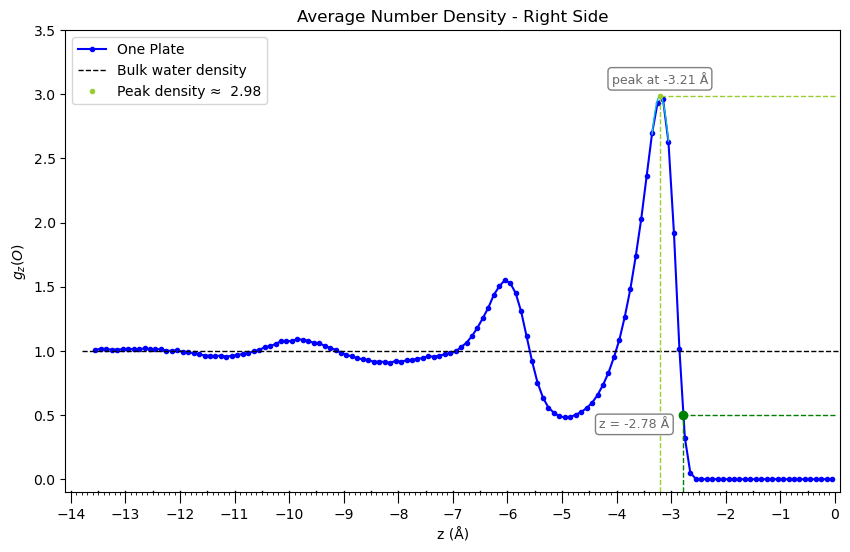

In [117]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
import numpy as np
import os

input_file = '/gibbs/joecruz/wu_hydroplates/one_plate/gzInterference/rightSide.dat'
output_path = '/gibbs/arghavan/hp-results-pc/'

data = np.loadtxt(input_file)

number_of_voxels = 170*170

x = data[:, 0]
number_density = data[:, 1]/number_of_voxels

np.savetxt(f'{output_path}gZ-one-plate-300K-rightSide.dat', 
        np.column_stack((x, number_density)), 
        header='x (Angstrom)    g_z(O)', 
        comments='')

half_density = 0.5
idx = np.where(np.diff(np.sign(number_density - half_density)))[0]
x_for_half = x[idx] + (half_density - number_density[idx]) * (x[idx+1] - x[idx]) / (number_density[idx+1] - number_density[idx])

print("x values where y=0.5:", x_for_half)




plt.figure(figsize=(10, 6))
plt.plot(x, number_density, 'bo-', markersize=3, label='One Plate', zorder=2)

plt.hlines(y=1.00, xmin=-13.8, xmax=0.2, color='black', linestyle='--', linewidth=1, label='Bulk water density')
plt.hlines(y=0.5, xmin=0, xmax=x_for_half[-1], color='green', linestyle='--', linewidth=1)

plt.vlines(x=x_for_half[-1], ymin=-0.1, ymax=0.5, color='green', linestyle='--', linewidth=1)

plt.scatter(x_for_half[-1], [half_density], color='green', zorder=3)


plt.text(x_for_half[-1] - 0.9, 0.4, f"z = {x_for_half[-1]:.2f} Å", ha='center', fontsize=9, color='dimgrey',
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3'))

# ------------------------

def gaussian(x, a, x0, sigma):
    return a * np.exp(-((x - x0)**2) / (2 * sigma**2))

# find raw peaks
peak_indices, _ = find_peaks(number_density, height=1.2) 
x_peaks_init = x[peak_indices]
x0_guess = x_peaks_init[-1]
fitted_peaks = []
# gaussian fit
# for x0_guess in x_peaks_init:

# mask ±0.3 around initial peak guess
mask = (x > x0_guess - 0.25) & (x < x0_guess + 0.15)
x_fit = x[mask]
y_fit = number_density[mask]

# if len(x_fit) < 5:
    # continue

# initial guess [a, x0, sigma]
p0 = [np.max(y_fit), x0_guess, 0.2]

try:
    popt, _ = curve_fit(gaussian, x_fit, y_fit, p0=p0)
    a_fit, x_peak, sigma_fit = popt
    y_peak = gaussian(x_peak, *popt)

    # saving peak info
    fitted_peaks.append((x_peak, y_peak))
    # fitting
    x_dense = np.linspace(x_fit.min(), x_fit.max(), 500)

    plt.plot(x_dense, gaussian(x_dense, *popt), 'tab:cyan', linewidth = 1)
    plt.plot(x_peak, y_peak, 'o', markersize=3, color='yellowgreen', label=f'Peak density ≈  {y_peak:.2f}')

except RuntimeError:
    print(f"Fit failed for peak near x = {x0_guess:.2f}")

if fitted_peaks:
    z1, y1 = fitted_peaks[-1]

    plt.hlines(y=y1, xmin=0, xmax=z1, color='yellowgreen', linestyle='--', linewidth=1)
    plt.vlines(x=z1, ymin=-0.1, ymax=y1, color='yellowgreen', linestyle='--', linewidth=1)
    plt.text(z1, y1 + 0.1, f"peak at {z1:.2f} Å", ha='center', fontsize=9, color='dimgrey',
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3'))

# -------------------------

plt.title('Average Number Density - Right Side')
plt.xlabel('z (Å)')
plt.ylabel(r'$g_z(O)$')
plt.ylim(-0.1, 3.5)
plt.xlim(-14.1,0.1)
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(0.1))

medium_ticks = np.arange(-14, 0, 0.5)
plt.gca().set_xticks(medium_ticks, minor=True)  # treat as minor ticks

small_ticks = np.arange(-14, 0, 0.1)
plt.gca().set_xticks(small_ticks, minor=True)

# Adjust styles
plt.tick_params(axis='x', which='major', length=8)   # big ticks
plt.tick_params(axis='x', which='minor', length=2)   # default for all minor ticks

# To make 0.5 ticks longer than 0.1 ticks, we can redraw them manually
for t in medium_ticks:
    plt.gca().axvline(t, ymin=0, ymax=0.003, color='k', lw=1)


plt.legend()

plot_path = f"{output_path}plots/"
os.makedirs(os.path.dirname(plot_path), exist_ok=True)

plt.savefig(f'{plot_path}/one-plate-right-side.png', dpi=300)

